In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

BAD_SCORE = -999999.9
BAD_PIXELS = -1

NEEDED = ["signal_score", "n_pixels"]

def load_folder_scores(folder: Path):
    """
    Load all *_scores.csv in a folder, keep only needed columns, clean sentinels.
    Returns a DataFrame with columns: signal_score, n_pixels, y_logpix
    """
    files = sorted(folder.glob("*_scores.csv"))
    if not files:
        return None

    dfs = []
    for f in files:
        df = pd.read_csv(f, usecols=lambda c: c in NEEDED)
        if not set(NEEDED).issubset(df.columns):
            continue
        dfs.append(df[NEEDED].copy())

    if not dfs:
        return None

    df = pd.concat(dfs, ignore_index=True)

    # Clean sentinel / invalid rows
    df = df[(df["signal_score"] != BAD_SCORE) & (df["n_pixels"] != BAD_PIXELS) & (df["n_pixels"] >= 0)].copy()

    # Helpful derived axis
    df["y_logpix"] = np.log10(df["n_pixels"].to_numpy(dtype=float) + 1.0)

    return df

In [2]:
INFER_BASE = Path("/home/hep/an1522/dark_tridents_wspace/outputs/inference")

folders_to_plot = {
    "Run_1_Samples (MPID)": INFER_BASE / "run1_samples_mpid",
    "Run_1_Samples (ResNet34_GN)": INFER_BASE / "run1_samples_resnet34_gn",
    "Run_1_Signal (MPID)": INFER_BASE / "run1_signal_mpid",
    "Run_1_Signal (ResNet34_GN)": INFER_BASE / "run1_signal_resnet34_gn",
    "Run_3_Samples (MPID)": INFER_BASE / "run3_samples_mpid",
    "Run_3_Samples (ResNet34_GN)": INFER_BASE / "run3_samples_resnet34_gn",
    "Run_3_Signal (MPID)": INFER_BASE / "run3_signal_mpid",
    "Run_3_Signal (ResNet34_GN)": INFER_BASE / "run3_signal_resnet34_gn",
}

data = {}
for name, folder in folders_to_plot.items():
    df = load_folder_scores(folder)
    if df is None or df.empty:
        print(f"[warn] no usable *_scores.csv found in {folder}")
        continue
    data[name] = df
    print(f"[ok] {name}: rows={len(df):,}")

[ok] Run_1_Samples (MPID): rows=20,955
[ok] Run_1_Samples (ResNet34_GN): rows=20,955
[ok] Run_1_Signal (MPID): rows=208,556
[ok] Run_1_Signal (ResNet34_GN): rows=208,556
[ok] Run_3_Samples (MPID): rows=29,374
[ok] Run_3_Samples (ResNet34_GN): rows=29,374
[ok] Run_3_Signal (MPID): rows=262,897
[ok] Run_3_Signal (ResNet34_GN): rows=262,897


In [3]:
# Shared x/y extent across ALL plots (so bins correspond to the same space)
x_min, x_max = 0.0, 1.0

# y extent from global min/max log pixels across all datasets
y_min = min(df["y_logpix"].min() for df in data.values())
y_max = max(df["y_logpix"].max() for df in data.values())

extent = (x_min, x_max, y_min, y_max)

# Hexbin binning choices (keep these fixed for fairness)
GRIDSIZE = 120     # increase for finer bins, decrease for speed
MINCNT   = 1       # ignore empty bins

# First pass: get GLOBAL max bin count for shared color scale
global_max_count = 1
for name, df in data.items():
    fig, ax = plt.subplots(figsize=(7, 5))
    hb = ax.hexbin(
        df["signal_score"], df["y_logpix"],
        gridsize=GRIDSIZE,
        extent=extent,
        mincnt=MINCNT
    )
    cmax = float(np.nanmax(hb.get_array())) if hb.get_array().size else 1.0
    global_max_count = max(global_max_count, cmax)
    plt.close(fig)

print("Global max bin count:", global_max_count)
shared_norm = LogNorm(vmin=1, vmax=global_max_count)

Global max bin count: 3784.0


saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-1-Samples-MPID.png


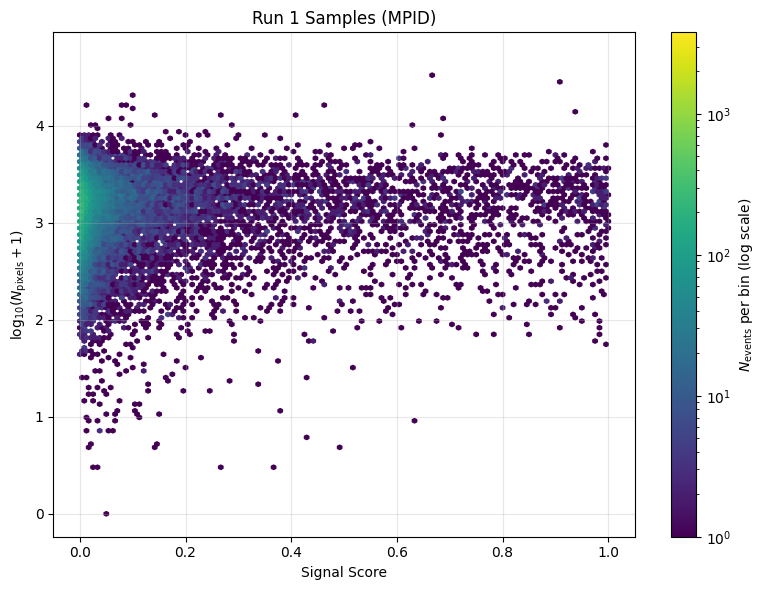

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-1-Samples-ResNet34-GN.png


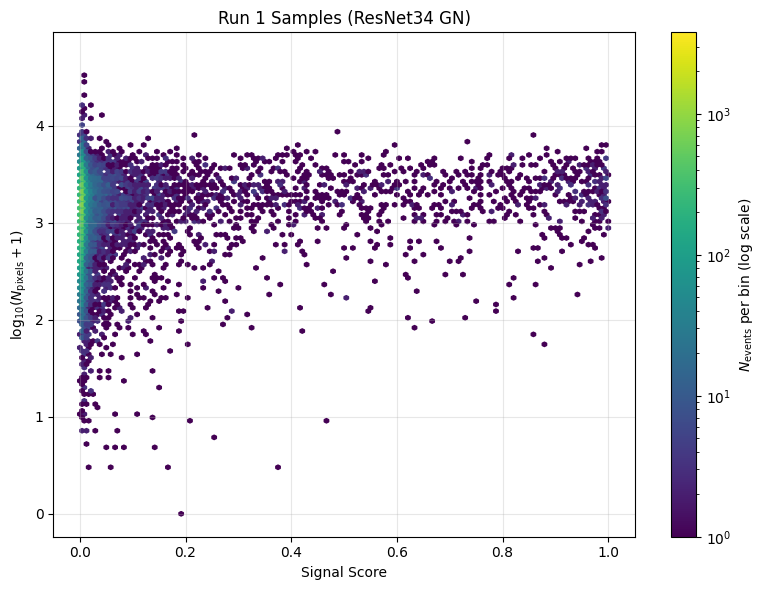

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-1-Signal-MPID.png


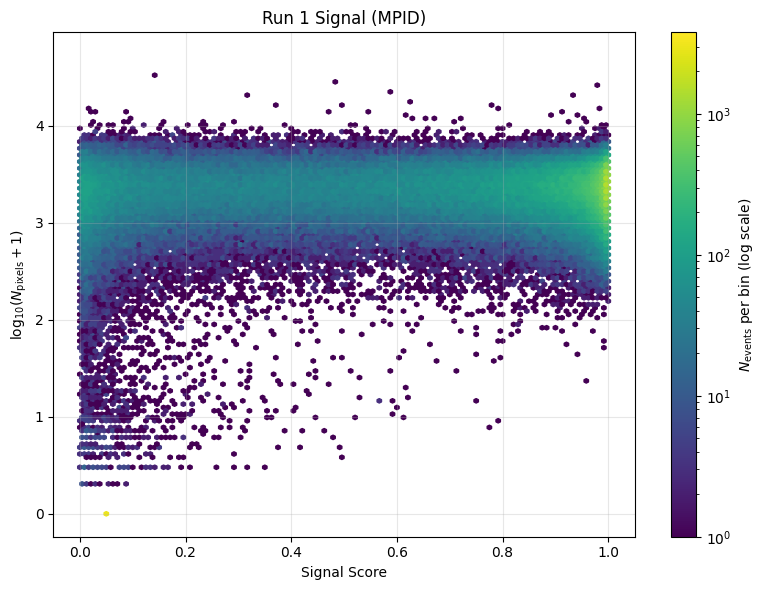

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-1-Signal-ResNet34-GN.png


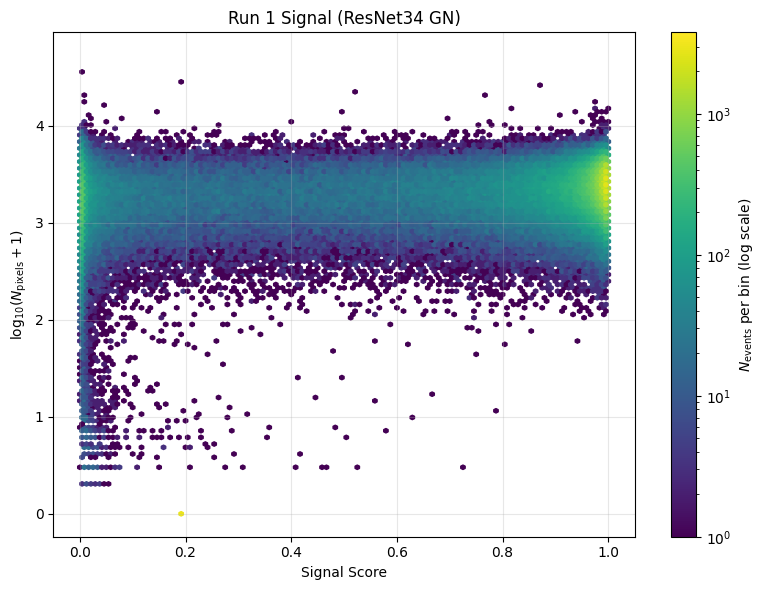

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-3-Samples-MPID.png


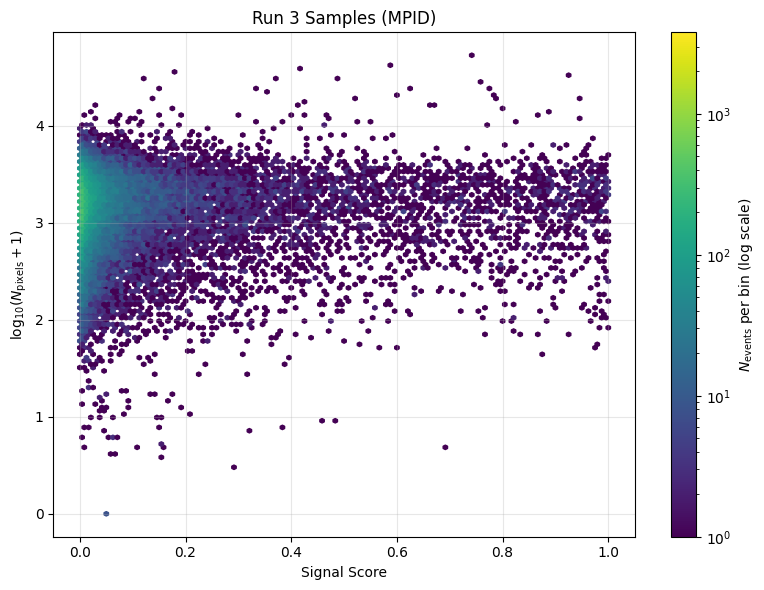

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-3-Samples-ResNet34-GN.png


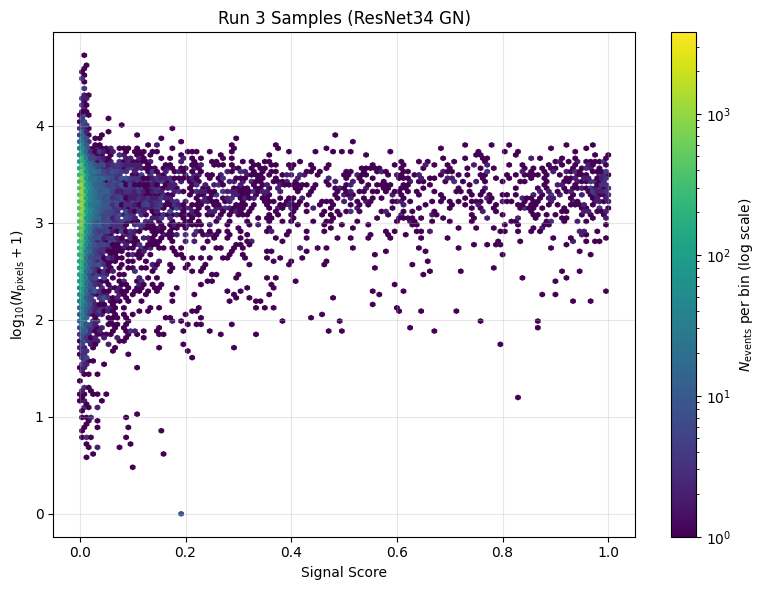

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-3-Signal-MPID.png


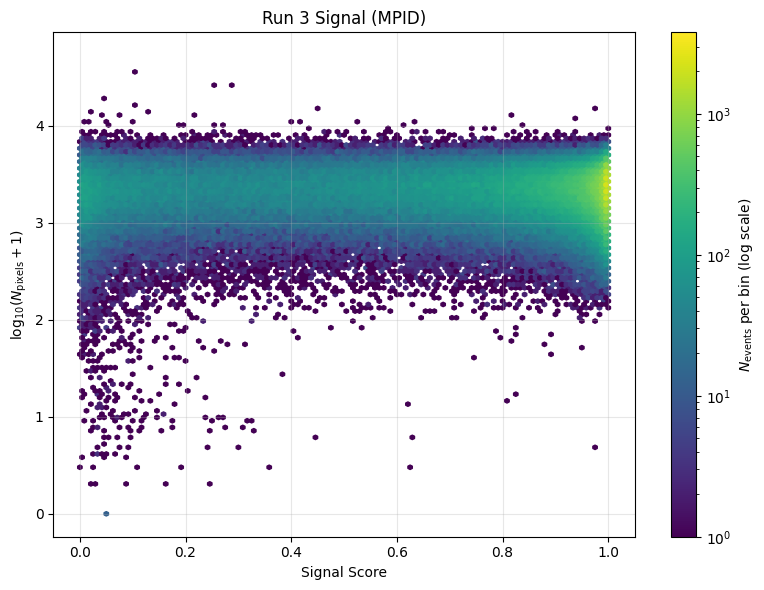

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-signal-score-vs-npix--Run-3-Signal-ResNet34-GN.png


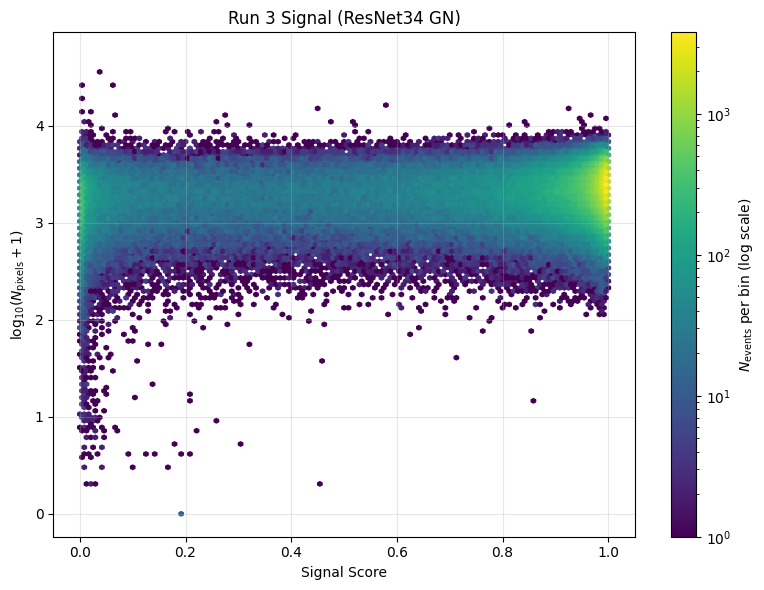

In [4]:
out_dir = Path("/home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels")
out_dir.mkdir(parents=True, exist_ok=True)

import re

def _pretty_no_underscores(s: str) -> str:
    # Replace underscores with spaces (and tidy)
    s = s.replace("_", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _safe_filename_no_underscores(s: str) -> str:
    # Make a filesystem-safe name with no underscores
    s = _pretty_no_underscores(s)
    s = re.sub(r"[^\w\s\-\.]", "", s)   # remove weird chars (keeps letters/numbers/spaces/-/.)
    s = s.strip().replace(" ", "-")     # hyphens instead of spaces
    s = re.sub(r"-{2,}", "-", s)        # collapse multiple hyphens
    return s

def plot_one(name, df, save=True):
    # What you SEE (no underscores)
    title_text = _pretty_no_underscores(name)

    fig, ax = plt.subplots(figsize=(8, 6))

    hb = ax.hexbin(
        df["signal_score"], df["y_logpix"],
        gridsize=GRIDSIZE,
        extent=extent,
        mincnt=MINCNT,
        norm=shared_norm
    )

    # Title: plain text (no underscores)
    ax.set_title(title_text)

    # LaTeX axis labels
    ax.set_xlabel("Signal Score")  # signal score
    ax.set_ylabel(r"$\log_{10}\!\left(N_{\mathrm{pixels}} + 1\right)$")

    ax.grid(True, alpha=0.3)

    # Optional borderline at 0.5
    # ax.axvline(0.5, linewidth=1)

    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label(r"$N_{\mathrm{events}}\ \mathrm{per\ bin}$ (log scale)")

    fig.tight_layout()

    if save:
        safe = _safe_filename_no_underscores(title_text)
        out_path = out_dir / f"hexbin-signal-score-vs-npix--{safe}.png"
        fig.savefig(out_path, dpi=200)
        print("saved:", out_path)

    plt.show()

for name, df in data.items():
    plot_one(name, df, save=True)